# PFC 2019 simulations

In [23]:
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import numpy as np
import glob, os, pickle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 2.5 * matplotlib.rcParams['figure.dpi']

import astropy
from astropy.time import Time

import enterprise
from enterprise.pulsar import Pulsar

import enterprise_extensions
from enterprise_extensions import models, model_utils

import libstempo as T2, libstempo.toasim as LT, libstempo.plot as LP
from ephem import Ecliptic, Equatorial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

#plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}',r'\usepackage{amsbsy}',
                                r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5)}
plt.rcParams.update(params)

## Useful functions

In [3]:
import pandas as pd

In [4]:
def year2mjd(year):
    # rounds to nearest year
    return float(Time("{}-01-01T00:00:00".format(str(int(np.rint(year)))), 
                      format='isot').mjd)

def mjd2year(mjd):
    return float(Time(mjd, format='mjd').decimalyear)

## Process data

In [5]:
data = pd.read_csv('../data/pfc2019/RMSonlyvsTime2018-GBTAO-StatusQuoNoDSA2000-SimulationI_edited.csv',header=0,skip_blank_lines=True,)

In [6]:
for ii,name in data.iterrows():
    print(name)

PSR            J0340+4130
Observatory           GBT
Nepochs                 4
Epoch1               2005
RMS1                  NaN
Epoch2               2012
RMS2              1.07709
Epoch3               2021
RMS3             0.539008
Epoch4               2026
RMS4             0.539008
Epoch5                NaN
RMS5                  NaN
Name: 0, dtype: object
PSR            J0605+3757
Observatory           GBT
Nepochs                 4
Epoch1               2005
RMS1                  NaN
Epoch2               2017
RMS2              2.08495
Epoch3               2021
RMS3              1.04261
Epoch4               2026
RMS4              1.04261
Epoch5                NaN
RMS5                  NaN
Name: 1, dtype: object
PSR            J0610-2100
Observatory           GBT
Nepochs                 4
Epoch1               2005
RMS1                  NaN
Epoch2               2017
RMS2             0.996647
Epoch3               2021
RMS3             0.499125
Epoch4               2026
RMS4             0

In [7]:
### Make fake dataset
for jj,name in data.iterrows():
    
    psrname = name.PSR
    
    try:
        file = open('../data/pfc2019/popsynth_par_files/' + psrname + '.par', mode='r')
        file.close()
        par = '../data/pfc2019/popsynth_par_files/' + psrname + '.par'
    except:
        try:
            if psrname == 'J1713+0747':
                ext = '.working.t2.par'
            else:
                ext = '.working.par'
            file = open('../data/pfc2019/real_par_files/' + psrname + ext, mode='r')
            file.close()
            par = '../data/pfc2019/real_par_files/' + psrname + ext
        except:
            print('need',psrname)

## Creating tim files

In [8]:
sim_type = 'status_quo' # 'status_quo', 'lose_ao', or 'burning_dumptser'

In [9]:
timcheck=glob.glob('../data/pfc2019/tim_{}/*.tim'.format(sim_type))
Ltim=len(timcheck)
print(Ltim)
idxs = [ii for ii in range(Ltim)]

79


In [12]:
if not os.path.exists('../data/pfc2019/tim_{}/'.format(sim_type)):
    os.makedirs('../data/pfc2019/tim_{}/'.format(sim_type))

sims = []
start_data = []
for jj,name in data.iterrows():
    
    psrname = name.PSR
    print('\r'+psrname+'      ',end='',flush=True)
    if os.path.exists('../data/pfc2019/tim_{}/{}.tim'.format(sim_type,psrname)):
        sims.append(None)
#     elif psrname in ['J2017+0603']:#'J1022+1001''J0621+2514','J0709+0458']:
#         sims.append(None)
    else:
        rms = np.array([name.RMS1, name.RMS2, name.RMS3, 
                        name.RMS4, name.RMS5])
        rms[rms=='gap'] = np.inf
        rms = np.array(rms,dtype=float)
        epoch = np.array([name.Epoch1, name.Epoch2, name.Epoch3, 
                          name.Epoch4, name.Epoch5])

        ### Start and End year
        start_yr = epoch[np.where(~np.isnan(rms))[0][0]]
        start_yr_mjd = year2mjd(start_yr)
        #
        end_yr = 2045.0
        end_yr_mjd = year2mjd(end_yr)

        ### Spacing and obstimes
        spacing = 365.25 / 20.0 # days between observations
        #
        obstimes = np.arange(start_yr_mjd, end_yr_mjd, spacing)
        # removing data gaps
        for kk,rmss in enumerate(rms):
            if np.isinf(rmss):
                mask = np.logical_and(obstimes >= year2mjd(epoch[kk]), 
                                      obstimes <= year2mjd(epoch[kk+1]))
                obstimes = obstimes[~mask]

        ### Segmenting obstimes based on hardware/telescope switches
        stops = list(epoch[np.where(~np.isnan(rms))[0]]) + [end_yr]
        stops = [year2mjd(yr) for yr in stops]
        errors = list(rms[np.where(~np.isnan(rms))[0]])

        ### Masking sections of data based on these stops
        masks = []
        for kk,stop in enumerate(stops):
            if kk < len(stops)-1:
                masks.append(np.logical_and(obstimes >= stops[kk], 
                                            obstimes <= stops[kk+1]))

        ### Applying RMS errors
        toa_errs = np.ones_like(obstimes)
        for kk,mask in enumerate(masks):
            toa_errs[mask] *= float(errors[kk])

        ### Make fake dataset
        try:
            file = open('../data/pfc2019/popsynth_par_files/' + psrname + '.par', mode='r')
            file.close()
            par = '../data/pfc2019/popsynth_par_files/' + psrname + '.par'

            sims.append(LT.fakepulsar(parfile=par, obstimes=obstimes, 
                                      toaerr=toa_errs, 
                                      observatory=name.Observatory.lower()))
            # white noise
            LT.add_efac(sims[jj])
            # save .tim
            sims[jj].savetim('../data/pfc2019/tim_{}/'.format(sim_type) 
                                 + sims[jj].name + '.tim')
            ###
            start_data.append([psrname, start_yr, start_yr_mjd])
            print(psrname, par, start_yr_mjd, end_yr_mjd, len(stops), len(masks), len(errors))

        except:
            if psrname == 'J1713+0747':
                ext = '.working.t2.par'
            else:
                ext = '.working.par'
#             try:
            file = open('../data/pfc2019/real_par_files/' + psrname + ext, mode='r')
            file.close()
            par = '../data/pfc2019/real_par_files/' + psrname + ext

            sims.append(LT.fakepulsar(parfile=par, obstimes=obstimes, 
                                  toaerr=toa_errs, 
                                  observatory=name.Observatory.lower()))
            # white noise
            LT.add_efac(sims[jj])
            # save .tim
            sims[jj].savetim('../data/pfc2019/tim_{}/'.format(sim_type) 
                                 + sims[jj].name + '.tim')
            ###
            start_data.append([psrname, start_yr, start_yr_mjd])
            print(psrname, par, start_yr_mjd, end_yr_mjd, len(stops), len(masks), len(errors))
#             except:
#                 print('no par file for {}...skipping'.format(psrname))

J0621+2514          J0621+2514 ../data/pfc2019/real_par_files/J0621+2514.working.par 57388.0 67981.0 4 3 3
J0709+0458      

/Users/hazboun/anaconda3/envs/pint/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


J0709+0458 ../data/pfc2019/real_par_files/J0709+0458.working.par 57388.0 67981.0 4 3 3
J2017+0603      J2017+0603 ../data/pfc2019/real_par_files/J2017+0603.working.par 55562.0 67981.0 5 4 4
J224260+381408      

In [13]:
#start_data = np.array(start_data)
#start_data[start_data[:,1].argsort()]

#fil = open('sims_psr_startdata_{}.txt'.format(sim_type),'w')
#for line in start_data[start_data[:,1].argsort()]:
#    print >>fil, line[0], line[1], line[2]
#fil.close()

# Read In And Check Pulsars

In [14]:
import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import signal_base

import enterprise_extensions
from enterprise_extensions import models, model_utils
import glob

In [15]:
psr_test = Pulsar('../data/pfc2019/real_par_files/J0340+4130.working.par', '../data/pfc2019/tim_status_quo/J0340+4130.tim', ephem='DE436')

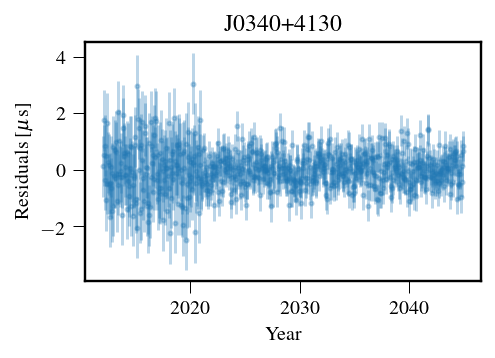

In [16]:
plt.errorbar([mjd2year(p) for p in psr_test.toas/86400.0], 
             psr_test.residuals/1e-6, psr_test.toaerrs/1e-6, 
             alpha=0.3, fmt='.')

plt.xlabel(r'Year')
plt.ylabel(r'Residuals [$\mu$s]')
plt.title(psr_test.name)
plt.show()

In [20]:
#Pull paths in with glob
timpaths = sorted(glob.glob('../data/pfc2019/tim_status_quo/*.tim'))
parpaths = glob.glob('../data/pfc2019/popsynth_par_files/*.par')
parpaths.extend(glob.glob('../data/pfc2019/real_par_files/*.par'))
parpaths = sorted(parpaths)
psr_names = [t.split('/')[-1].split('.')[0] for t in timpaths]
#Check to see that numbers match
len(timpaths), len(parpaths)

(107, 107)

In [18]:
# If they don't match you can use this to see which one don't match
# [p for p in parpaths if p.split('/')[-1].split('.')[0]
#             not in psr_names]

['../data/pfc2019/real_par_files/B1937+21.working.par',
 '../data/pfc2019/real_par_files/J0824+0028.working.par']

In [21]:
psrs=[]
for t,p in zip(timpaths,parpaths):
    psrs.append(Pulsar(t,p,ephem='DE436'))

In [24]:
with open('../data/pfc2019/tim_status_quo/pfc2019_status_quo_ePsrs.pkl', 'wb') as fin:
    pickle.dump(psrs,fin)